In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import utils as utils

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM, Dense

from gensim.models import Word2Vec

from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuasegal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('text_entailment_dataset/train.csv')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)  # Shuffle with fixed seed for reproducibility

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)

# Write the training and validation DataFrames to separate CSV files
train_df.to_csv('text_entailment_dataset/train_data.csv', index=False)
validation_df.to_csv('text_entailment_dataset/validation_data.csv', index=False)


train_dataset = df = pd.read_csv('text_entailment_dataset/train_data.csv')
validation_dataset = df = pd.read_csv('text_entailment_dataset/validation_data.csv')
test_dataset = df = pd.read_csv('text_entailment_dataset/test_data.csv')


In [3]:
train_dataset.head()

,premise,hypothesis,label
0,a dog chases a red ball.,A cute dog paly with a ball.,0
1,A carefully dressed you boy is nonverbally com...,A young boy dressed in a potato sack is trying...,2
2,A black and white dog jumps in the snow.,The dogs are leaping into the snow.,0
3,A man singing and playing guitar on a busy sid...,A man is performing on a city sidewalk,0
4,A man holding a rifle next to his brown dog.,A man is climbing a tree.,2


In [4]:
train_dataset.shape

(494424, 3)

In [5]:
validation_dataset.head()

,premise,hypothesis,label
0,A young couple looking at different types and ...,a couple is looking,0
1,A man in a purple had climbs a rocky wall with...,A man is going to the temple.,2
2,A group of friends playing cards and trying to...,The people are playing a card game.,0
3,People looking at fish at an aquarium.,People looking at fish.,0
4,An older lady blowing out a 9 and a 0 number c...,A woman drinks coffee while driving.,2


In [6]:
validation_dataset.shape

(54937, 3)

In [7]:
test_dataset.head()

,premise,hypothesis
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,This church choir sings to the masses as they ...,The church is filled with song.
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.


In [8]:
test_dataset.shape

(9824, 2)

In [9]:
train_dataset[["premise"]] = train_dataset[["premise"]].astype(str)
train_dataset["premise"] = train_dataset["premise"].apply(utils.change_lower)
train_dataset["premise"] = train_dataset["premise"].apply(utils.clean_data)
train_dataset["premise"] = train_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = train_dataset[["hypothesis"]].astype(str)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.change_lower)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.clean_data)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.remover)

validation_dataset[["premise"]] = validation_dataset[["premise"]].astype(str)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.change_lower)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.clean_data)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.remover)

validation_dataset[["hypothesis"]] = validation_dataset[["hypothesis"]].astype(str)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.change_lower)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.clean_data)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.remover)

test_dataset[["premise"]] = test_dataset[["premise"]].astype(str)
test_dataset["premise"] = test_dataset["premise"].apply(utils.change_lower)
test_dataset["premise"] = test_dataset["premise"].apply(utils.clean_data)
test_dataset["premise"] = test_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = test_dataset[["hypothesis"]].astype(str)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.change_lower)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.clean_data)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.remover)

In [10]:
X_train = train_dataset['premise'] + train_dataset['hypothesis']
X_Val = validation_dataset['premise'] + validation_dataset['hypothesis']
X_test = test_dataset['premise'] + test_dataset['hypothesis']


In [11]:
# Tokenize text data
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_Val)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in train_sequences)
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sequences, vector_size=100, window=5, min_count=1, workers=4)

print("Size of Vocabulary:", len(tokenizer.word_index))
print("Size of Train Sequences:", len(train_sequences))
print("Size of Validation Sequences:", len(val_sequences))
print("Size of Test Sequences:", len(test_sequences))



Size of Vocabulary: 143279
Size of Train Sequences: 494424
Size of Validation Sequences: 54937
Size of Test Sequences: 9824


In [12]:
# Generate word embeddings for each word in the sequences and pad sequences
train_vectorized_data = []
for seq in train_sequences:
    # Generate embeddings for individual words in the sequence
    word_embeddings = [word2vec_model.wv[word_index] for word_index in seq]
    # Pad the sequence of embeddings to the maximum length
    padded_embeddings = pad_sequences([word_embeddings], maxlen=max_sequence_length, padding='post', dtype='float32')[0]

    # Append padded embeddings to vectorized_data
    train_vectorized_data.append(padded_embeddings)

# Convert vectorized data to numpy array
train_vectorized_data = np.array(train_vectorized_data)

print("Vectorized Train Data Shape:", train_vectorized_data.shape)

Vectorized Train Data Shape: (494424, 64, 100)


In [13]:
# Generate embeddings for validation set
val_vectorized_data = []
for seq in val_sequences:
    word_embeddings = [word2vec_model.wv[word_index] if word_index in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word_index in seq]

    padded_embeddings = pad_sequences([word_embeddings], maxlen=max_sequence_length, padding='post', dtype='float32')[0]

    val_vectorized_data.append(padded_embeddings)

val_vectorized_data = np.array(val_vectorized_data)

print("Vectorized Validation Data Shape:", val_vectorized_data.shape)

Vectorized Validation Data Shape: (54937, 64, 100)


In [14]:
# Generate embeddings for test set
test_vectorized_data = []
for seq in test_sequences:
    word_embeddings = [word2vec_model.wv[word_index] if word_index in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word_index in seq]

    padded_embeddings = pad_sequences([word_embeddings], maxlen=max_sequence_length, padding='post', dtype='float32')[0]

    test_vectorized_data.append(padded_embeddings)

test_vectorized_data = np.array(test_vectorized_data)

print("Vectorized Test Data Shape:", test_vectorized_data.shape)


Vectorized Test Data Shape: (9824, 64, 100)


In [15]:
train_labels = train_dataset["label"]
validation_labels = validation_dataset["label"]

# Convert to one-hot encoded format
num_classes = len(set(train_labels))  # Calculate the number of classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

print("train label shape:", train_labels.shape)
print("val label shape:", validation_labels.shape)

train label shape: (494424, 3)
val label shape: (54937, 3)


In [16]:
def data_generator(X, y, batch_size):
    '''
    Returns a data generator to be used for training or validation.

    Yields batches of text sequences (tokenized) and corresponding one-hot encoded labels.

    Args:
    X: List of text sequences (e.g., tokenized sentences)
    y: List of corresponding one-hot encoded labels
    batch_size: Number of sequences per batch

    Returns:
    Data generator
    '''

    num_samples = len(X)
    num_batches = (num_samples + batch_size - 1) // batch_size  # Calculate total number of batches
    idx = 0  # Initialize index to keep track of where we are in the dataset

    while True:  # Loop indefinitely to generate batches
        batch_X = X[idx:idx+batch_size]
        batch_y = y[idx:idx+batch_size]

        # Yield the batch
        yield batch_X, batch_y

        # Move to the next batch
        idx += batch_size

        # If we reach the end of the dataset, start over
        if idx + batch_size > num_samples:
            idx = 0


In [17]:
print(train_vectorized_data.shape[1], ",", train_vectorized_data.shape[2])

64 , 100


In [18]:
batch_size = 32
train_generator = data_generator(train_vectorized_data, train_labels, batch_size)
val_generator = data_generator(val_vectorized_data, validation_labels, batch_size)

steps_per_epoch = len(train_vectorized_data) // batch_size
validation_steps = len(val_vectorized_data) // batch_size

In [19]:
sample_batch_X, sample_batch_y = next(train_generator)
print(sample_batch_X.shape)
print(sample_batch_y.shape)

(32, 64, 100)
(32, 3)


In [20]:
class MetricsCallback(Callback):
    def __init__(self, X_val, y_val):
        super(MetricsCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.metrics = {'epoch': [], 'precision': [], 'recall': [], 'f1': [], 'val_loss': [], 'val_accuracy': [], 'loss': [], 'accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.y_val, verbose=0)
        val_pred = self.model.predict(self.X_val)
        val_pred_classes = np.argmax(val_pred, axis=1)  # Convert probabilities to classes

        precision = precision_score(np.argmax(self.y_val, axis=1), val_pred_classes, average='weighted')
        recall = recall_score(np.argmax(self.y_val, axis=1), val_pred_classes, average='weighted')
        f1 = f1_score(np.argmax(self.y_val, axis=1), val_pred_classes, average='weighted')

        self.metrics['epoch'].append(epoch + 1)
        self.metrics['precision'].append(precision)
        self.metrics['recall'].append(recall)
        self.metrics['f1'].append(f1)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_accuracy'].append(val_accuracy)
        self.metrics['loss'].append(logs['loss'])
        self.metrics['accuracy'].append(logs['accuracy'])

        print("Epoch {}: Validation Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}, Val Loss = {:.4f}, Val Accuracy = {:.4f}".format(epoch + 1, precision, recall, f1, val_loss, val_accuracy))


In [21]:
# Define your LSTM model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(train_vectorized_data.shape[1], train_vectorized_data.shape[2])))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use sparse categorical cross-entropy for integer labels
              metrics=['accuracy'])

metrics_callback = MetricsCallback(val_vectorized_data, validation_labels)

# Define a checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10,
                              validation_data=val_generator, validation_steps=validation_steps, callbacks=[metrics_callback, checkpoint])




Epoch 1/10


2024-04-10 11:44:21.802624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-10 11:44:21.803580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-10 11:44:21.803996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15449/15450 [============================>.] - ETA: 0s - loss: 0.9683 - accuracy: 0.5260

2024-04-10 11:49:21.728657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-10 11:49:22.011124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-10 11:49:22.012500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

  22/1717 [..............................] - ETA: 8s

2024-04-10 11:49:52.887294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-10 11:49:52.888470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-10 11:49:52.889071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1717/1717 [==============================] - 10s 6ms/step
Epoch 1: Validation Precision = 0.5955, Recall = 0.5895, F1 Score = 0.5895, Val Loss = 0.8778, Val Accuracy = 0.5895

Epoch 1: val_loss improved from inf to 0.87784, saving model to best_model.h5
15450/15450 [==============================] - 341s 22ms/step - loss: 0.9683 - accuracy: 0.5260 - val_loss: 0.8778 - val_accuracy: 0.5895
Epoch 2/10
1717/1717 [==============================] - 11s 6ms/step
Epoch 2: Validation Precision = 0.6197, Recall = 0.6140, F1 Score = 0.6142, Val Loss = 0.8391, Val Accuracy = 0.6140

Epoch 2: val_loss improved from 0.87784 to 0.83916, saving model to best_model.h5
15450/15450 [==============================] - 580s 38ms/step - loss: 0.8495 - accuracy: 0.6093 - val_loss: 0.8392 - val_accuracy: 0.6140
Epoch 3/10
1717/1717 [==============================] - 11s 6ms/step
Epoch 3: Validation Precision = 0.6345, Recall = 0.6285, F1 Score = 0.6292, Val Loss = 0.8120, Val Accuracy = 0.6285

Epoch 3: val_l

In [22]:
epochs = metrics_callback.metrics['epoch']
precision = metrics_callback.metrics['precision']
recall = metrics_callback.metrics['recall']
f1 = metrics_callback.metrics['f1']
accuracy = metrics_callback.metrics['accuracy']
loss = metrics_callback.metrics['loss']
val_accuracy = metrics_callback.metrics['val_accuracy']
val_loss = metrics_callback.metrics['val_loss']

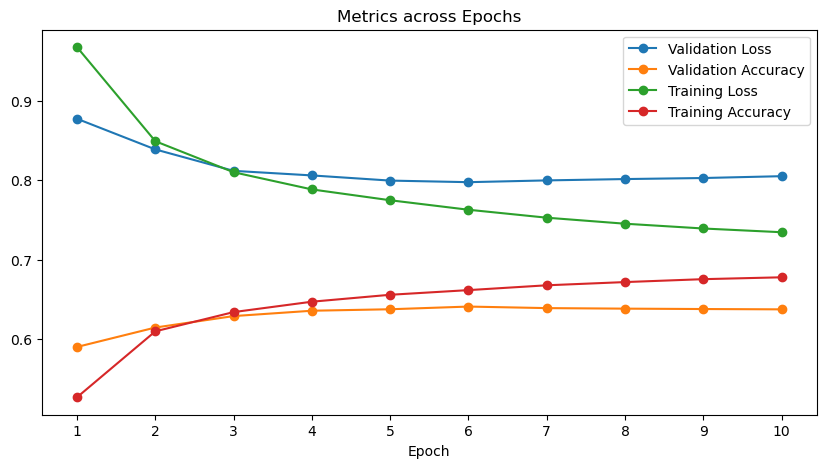

In [23]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("LSTM_RNN_val_loss_acc.pdf")  # Save the plot before showing
plt.show()


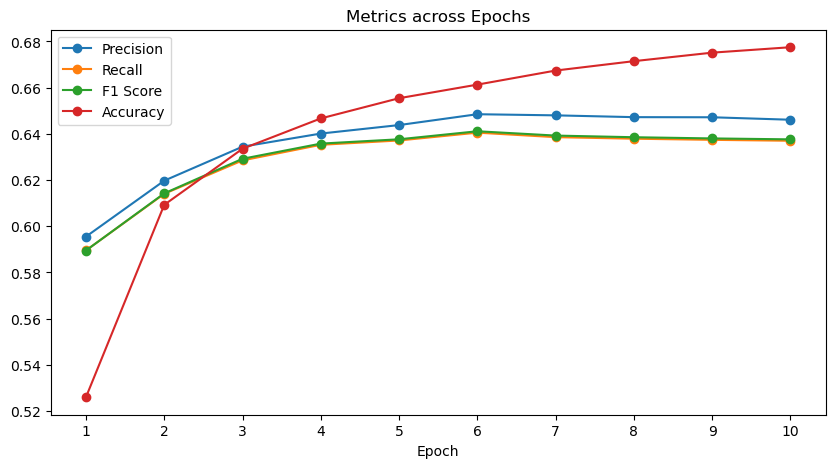

In [24]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1 Score')
plt.plot(epochs, accuracy, label='Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("LSTM_RNN_PRFA.pdf")
plt.show()

Best Epoch was Epoch 6: Val Precision = 0.6485, Val Recall = 0.6405, Val F1 Score = 0.6411, Val Loss = 0.7977, Val Accuracy = 0.6405, loss: 0.7629, accuracy: 0.6613